# Distribution of hyperparameters

In this notebook we generate a KDE plot and histogram for each of the numerical hyperparameters.

In [1]:
import os
from scipy.io import arff
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#import hyperimp.priors as priors

In [2]:
n = 10 # retrieve only 10 settings per dataset per classifier with highest accuracy  

# load data
data = arff.loadarff('data/meta_svm.arff')
svm = pd.DataFrame(data[0])
data = arff.loadarff('data/meta_random_forest.arff')
rf = pd.DataFrame(data[0])
data = arff.loadarff('data/meta_adaboost.arff')
ada = pd.DataFrame(data[0])

# load alg names and dataframes
g = svm.groupby('kernel')
algs = ['svm_' + s.decode('UTF-8') for s in list(g.groups.keys())] + ['rf', 'ada']
dfs_all = [g.get_group(x) for x in g.groups] + [rf, ada]

# retrieve top n for all dataframes
dfs = []
for df in dfs_all:
    groups = []
    for g in df.groupby(['task_id']):
        group = pd.DataFrame(g[1])
        group['task_id'] = g[0]
        groups.append(group.sort_values(by = 'y', ascending  = False)[0:n])
    dfs.append(pd.concat(groups))

In [3]:
# hyperparameters to be evaluated
alg_params = {'svm_poly': ['gamma','C','tol','coef0'],
              'svm_rbf': ['gamma','C','tol'],
              'svm_sigmoid': ['gamma','C','tol','coef0'],
              'rf': ['max_features','min_samples_leaf','min_samples_split'],
              'ada': ['learning_rate','max_depth','n_estimators']}

# parameters defined on a log scale
logs = ['gamma', 'C', 'tol', 'learning_rate']
integer = ['min_samples_leaf', 'min_samples_split', 'max_depth', 'n_estimators']

## Histograms

The number of bins is
    - log scale: 20
    - integer: max - min + 1
    - otherwise: 'auto'

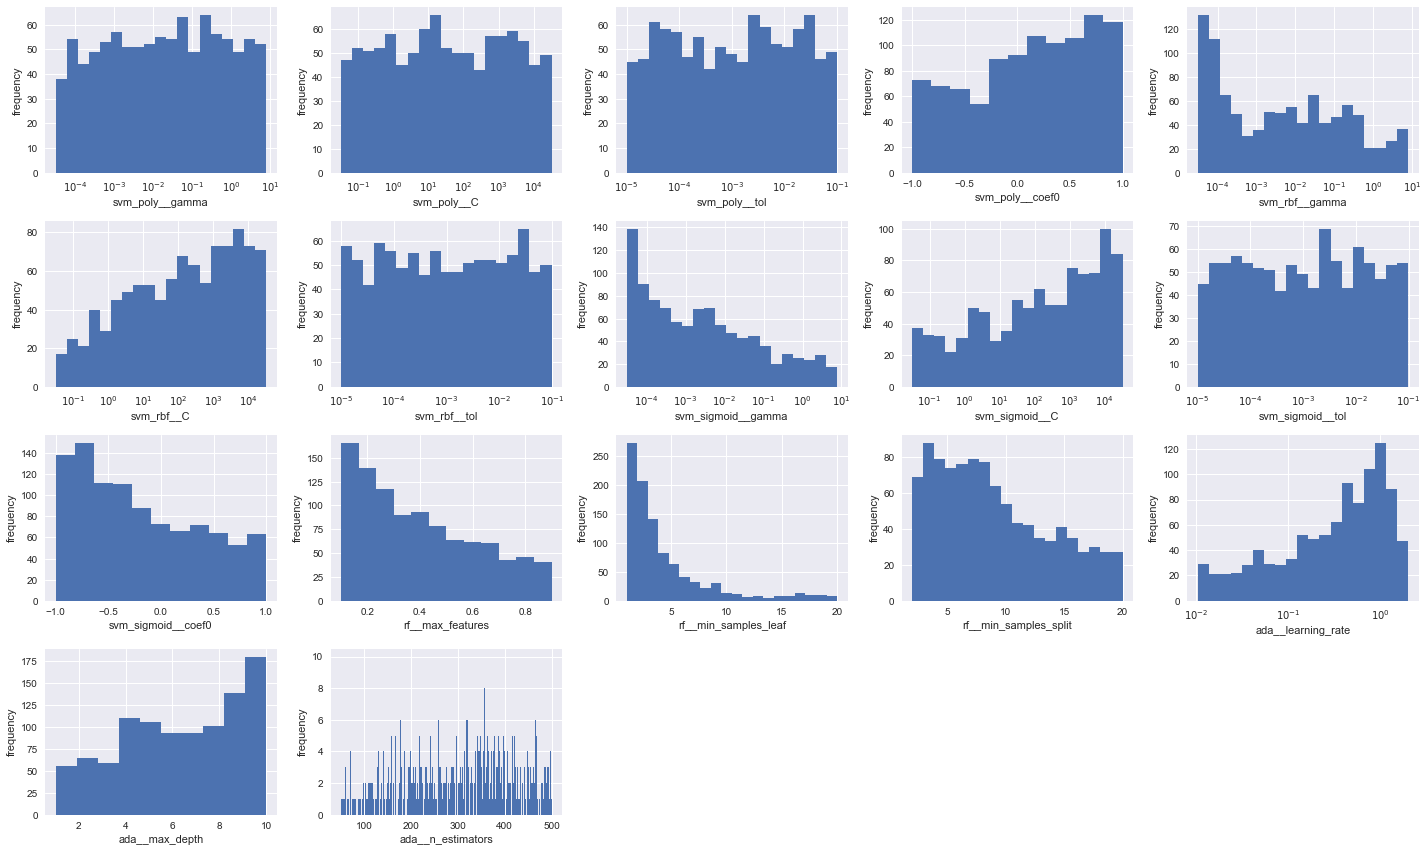

In [4]:
grid = True # put images on grid or not
cols = 5 # set nr columns in figure grid
ymax = None # set upper limit of plot; None for auto

if grid:
    nr_plots = sum([len(value) for key, value in alg_params.items()])
    rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
    plt.figure(figsize = (4*cols,3*rows))
    index = 0
for alg, df in zip(algs, dfs):
    for param in alg_params[alg]:
        if grid:
            index += 1
            plt.subplot(rows, cols, index)
        bins = 'auto'
        log = param in logs
        intg = param in integer
        if log:
            bins = np.logspace(np.log10(min(df[param])), np.log10(max(df[param])), 20)
            plt.xscale('log')
        if intg:
            bins = int(max(df[param]) - min(df[param]) + 1)
        plt.hist(df[param], bins = bins)
        plt.xlabel('%s__%s' % (alg, param))
        plt.ylim(0,ymax)
        plt.ylabel('frequency')
        plt.tight_layout()
        if not grid:
            #plt.savefig('figures/histograms/hist__%s__%s.eps' % (alg, param), format = 'eps')
            plt.show()
if grid:
    plt.show()

## KDE plots

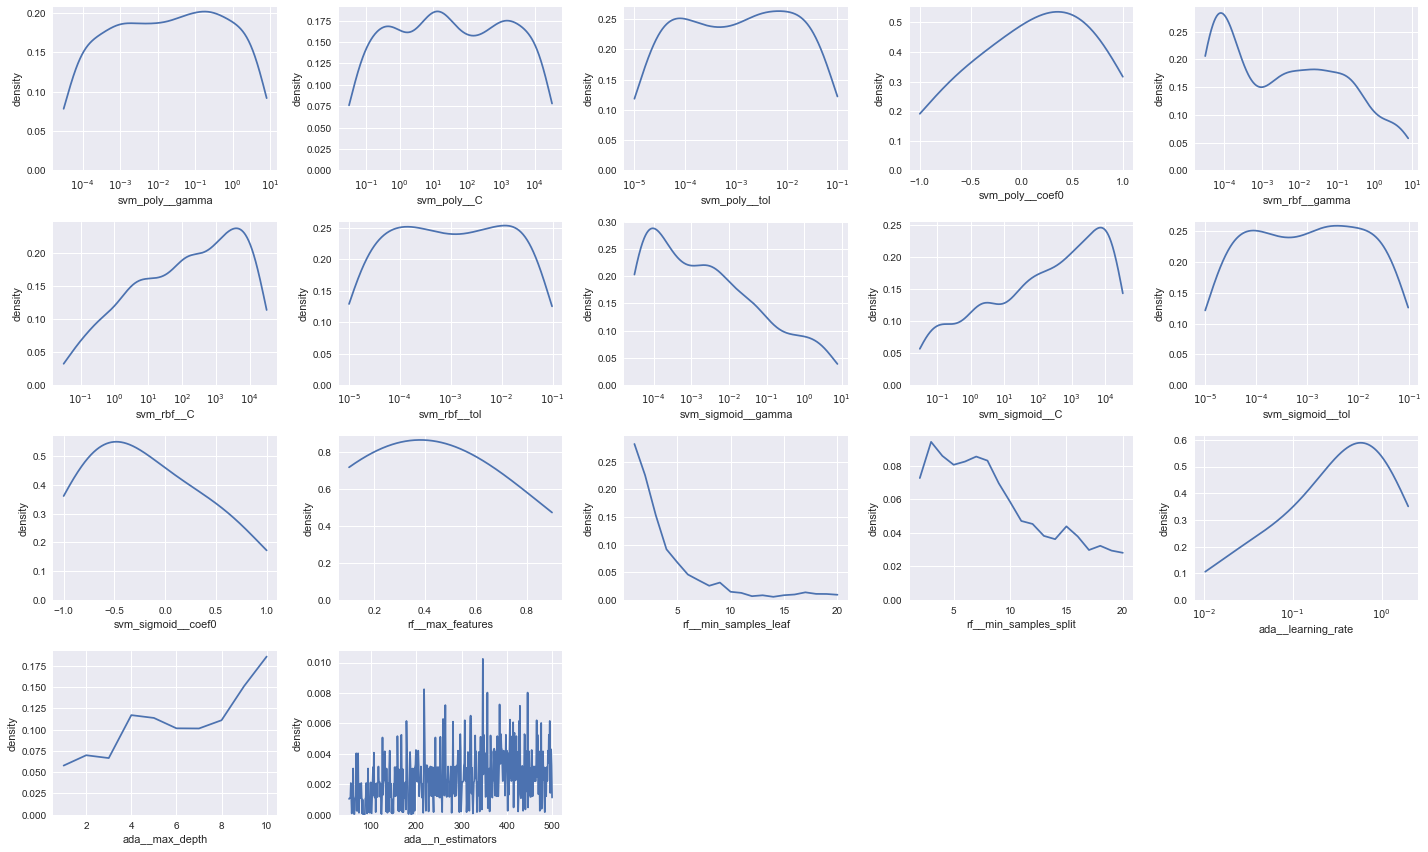

In [5]:
bandwidth = 0.4 # bandwidth of kde
step_size = 500 #nr of points that are evaluated for the kde
grid = True # put images on grid or not
cols = 5 # set nr columns in the grid
ymax = None #limit of y axis; None for auto

if grid:
    nr_plots = sum([len(value) for key, value in alg_params.items()])
    rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
    plt.figure(figsize = (4*cols,3*rows))
    index = 0
    
for alg, df in zip(algs, dfs):
    for param in alg_params[alg]:
        log = param in logs
        intg = param in integer
        
        if log:
            data = np.log10(df[param].as_matrix().transpose())
        else: 
            data = df[param].as_matrix().transpose()
            
        # fit kernel
        kde = stats.gaussian_kde(data, bw_method = bandwidth/data.std(ddof=1))
        
        # evaluate kernel
        x_min = min(data)
        x_max = max(data)
        if intg:
            steps = int(x_max - x_min + 1)
        else:
            steps = step_size
        x = np.linspace(x_min, x_max, steps)
        y = kde.evaluate(x)
        
        # plot figure
        if grid:
            index += 1
            plt.subplot(rows, cols, index)

        if log:
            x = 10**x
        plt.plot(x,y,'-')
        plt.ylim(0,ymax)
        plt.ylabel('density')
        plt.xlabel('%s__%s' % (alg, param))
        if log:
            plt.xticks(x)
            plt.xscale('log')
        plt.tight_layout()
        
        if not grid:
            #plt.savefig('figures/kdes/kde__%s__%s.eps' % (alg, param), format = 'eps')
            plt.show()
if grid:
    plt.show()

# Histogram + KDD plots

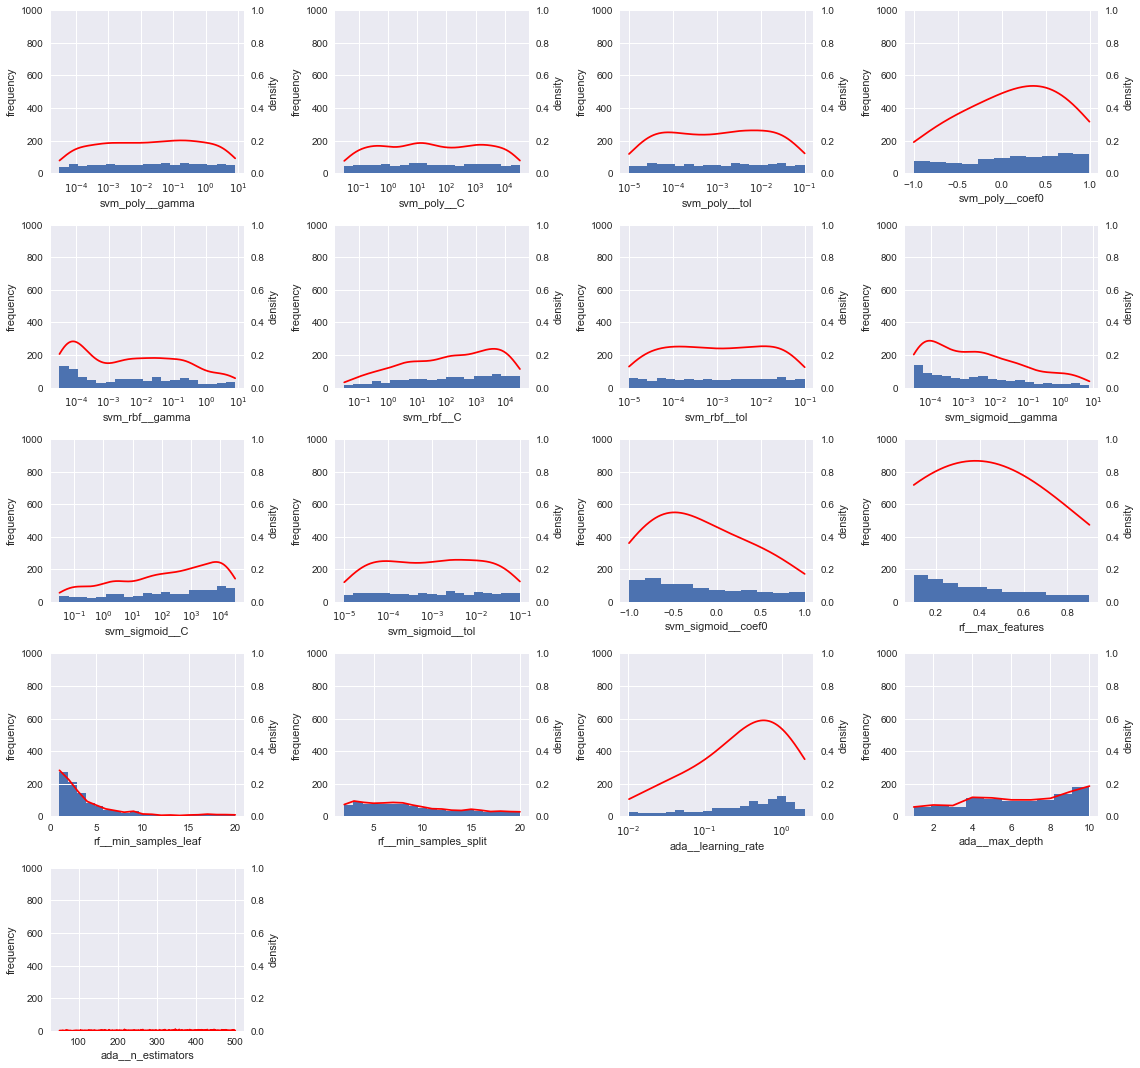

In [9]:
cols = 4 #nr columns in the grid

# Parameters for KDE
bandwidth = 0.4 # bandwidth of kde
step_size = 500 #nr of points that are evaluated for the kde

nr_plots = sum([len(value) for key, value in alg_params.items()])
rows = math.ceil(sum([len(value) for key, value in alg_params.items()])/cols)
fig = plt.figure(figsize = (4*cols,3*rows))
index = 1
for alg, df in zip(algs, dfs):
    for param in alg_params[alg]:
        log = param in logs
        intg = param in integer
        
        if log:
            data = np.log10(df[param].as_matrix().transpose())
        else: 
            data = df[param].as_matrix().transpose()
        
        # fit kernel
        kde = stats.gaussian_kde(data, bw_method = bandwidth/data.std(ddof=1))
        
        # evaluate kernel
        x_min = min(data)
        x_max = max(data)
        if intg:
            steps = int(x_max - x_min + 1)
        else:
            steps = step_size
        x = np.linspace(x_min, x_max, steps)
        y = kde.evaluate(x)
        if log:
            x = 10**x
        
        # create axes
        ax1 = fig.add_subplot(rows, cols, index)
        ax2 = ax1.twinx()
        
        # plot histogram
        bins = 'auto'
        if log:
            bins = np.logspace(np.log10(min(df[param])), np.log10(max(df[param])), 20)
            ax1.set_xscale('log')
        if intg:
            bins = int(max(df[param]) - min(df[param]) + 1)
            
        ax1.hist(df[param], bins = bins)
        ax1.set_xlabel('%s__%s' % (alg, param))
        ax1.set_ylabel('frequency')
        ax1.set_ylim(0,1000)
        
        # plot kde plot
        ax2.plot(x,y,'r-')
        ax2.set_ylim(0,1)
        ax2.set_ylabel('density')
        
        plt.grid(True)
        index += 1
        plt.tight_layout()
plt.show()